In [1]:
# bar plot of corr(pred rating, true rating) for full model, ratings-only model, and reports-only model 
# on semi-synthetic data for types with observed ratings
import os
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import seaborn as sns
plt.rcParams['font.family'] = 'serif'

# Set the font used for math expressions to LaTeX
plt.rcParams["mathtext.fontset"] = "cm"

In [2]:
# file paths
base_file = '/share/garg/311_data/sb2377/clean_codebase/three_year_base.csv'
type_rating_observed_base_file = '/share/garg/311_data/sb2377/clean_codebase/three_year_type_rating_observed_base.csv'
results_dir = '/share/garg/311_data/sb2377/results'

# user specified arguments
types = {'Street': 'StreetConditionDOT',
         'Park': 'MaintenanceorFacilityDPR',
         'Rodent': 'RodentDOHMH',
         'Food': 'FoodDOHMH',
         'DCWP': 'ConsumerComplaintDCWP'}
models = {'Full model': {'job_ids':[i * 3 + 3200 for i in range(20)]},
          'Ratings-only model': {'job_ids':[i * 3 + 3202 for i in range(20)]},
          'Reports-only model': {'job_ids':[i * 3 + 3201 for i in range(20)]}}
epoch = '59'

# plotting parameters
figsize=(4.5, 4.5)
bar_width = 0.25
figure_labels = ['Mean'] + list(types.keys())
save_path = "/home/sb2377/gnn_crowdsourced_model/figures/semisynthetic_ratings_observed.pdf"

In [3]:
# load files
base_df = pd.read_csv(base_file)
type_rating_observed_base_df = pd.read_csv(type_rating_observed_base_file)

In [4]:
# get type indices
# for df with all types
type_df = base_df[['typeagency', 'type_idxs']].drop_duplicates()
indices = {}
for type_name, type_id in types.items():
    idx = type_df[type_df['typeagency'] == type_id]['type_idxs'].iloc[0]
    indices[type_name] = idx

# for df with only types with observed ratings
type_df = type_rating_observed_base_df[['typeagency', 'type_idxs']].drop_duplicates()
type_rating_observed_indices = {}
for type_name, type_id in types.items():
    idx = type_df[type_df['typeagency'] == type_id]['type_idxs'].iloc[0]
    type_rating_observed_indices[type_name] = idx

In [5]:
# get predicted ratings for all jobs
checkpoint_file = '{}/job{}/model-epoch={}.ckpt'
results_file = '{}/job{}/epoch={}_test.pkl'
checkpoint_counters = {}
results_counters = {}
for m in models:
    checkpoint_counters[m] = 0
    results_counters[m] = 0
dfs = {}
for m in models:
    dfs[m] = []

for m in models:
    for i, job_idx in enumerate(models[m]['job_ids']):
        if os.path.exists(checkpoint_file.format(results_dir, job_idx, epoch)):
            checkpoint_counters[m] += 1
        if os.path.exists(results_file.format(results_dir, job_idx, epoch)):
            results_counters[m] += 1
            with open(results_file.format(results_dir, job_idx, epoch), 'rb') as file:
                pred_rating, true_rating, mask, node_embedding, type_embedding, node_idxs, type_idxs, demographics, pred_pt, true_t = pickle.load(file)

            df = pd.DataFrame()
            df['pred_rating'] = pred_rating
            df['true_rating'] = true_rating
            df['node_idxs'] = node_idxs
            df['type_idxs'] = type_idxs
            df['pred_pt'] = pred_pt
            df['true_t'] = true_t
            df['mask'] = mask

            dfs[m].append(df)

for m in models:
    print('{}: checkpoint files done = {}'.format(m, checkpoint_counters[m]))
    print('{}: results files done = {}'.format(m, results_counters[m]))

Full model: checkpoint files done = 20
Full model: results files done = 20
Ratings-only model: checkpoint files done = 20
Ratings-only model: results files done = 20
Reports-only model: checkpoint files done = 20
Reports-only model: results files done = 20


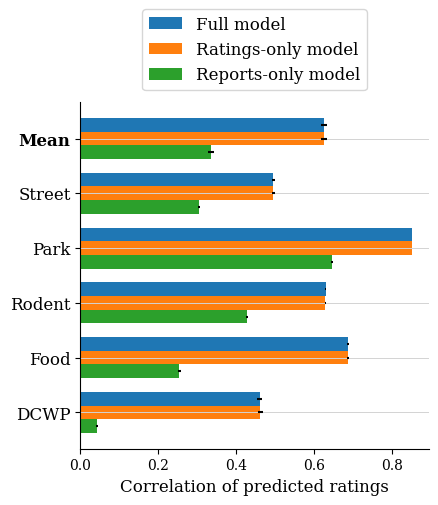

In [6]:
# plot figure
fig, ax = plt.subplots(figsize=figsize)

for i, m in enumerate(models):
    df_set = dfs[m]
    all_corrs = []
    
    # Loop through the indices to calculate correlations
    for t in types:
        idx = indices[t]
        type_rating_observed_idx = type_rating_observed_indices[t]
        corrs = []
        
        for observed_df in df_set:
            # Filter and group the data
            if m == 'Ratings-only model':
                observed_test_type_df = observed_df[observed_df['type_idxs'] == type_rating_observed_idx]
            else:
                observed_test_type_df = observed_df[observed_df['type_idxs'] == idx]
            node_df = observed_test_type_df.groupby(['node_idxs', 'type_idxs']).mean().reset_index()
            if m == 'Reports-only model':
                # for reports-only model, we use -P(T) as a proxy for r
                corr = pearsonr(-1 * node_df['pred_pt'], node_df['true_rating'])
                
            else:
                corr = pearsonr(node_df['pred_rating'], node_df['true_rating'])
            corrs.append(corr[0])

        corrs = np.array(corrs)
        all_corrs.append(corrs)
        
    # Calculate mean over all types with observed ratings
    all_corrs = np.array(all_corrs)
    mean_for_each_job = all_corrs.mean(axis=0)
    mean_for_each_type = all_corrs.mean(axis=1)
    mean_overall = all_corrs.mean()
    means = np.array([mean_overall] + list(mean_for_each_type))
    
    # Calculate 95% confidence intervals
    se_for_each_type = np.std(all_corrs, axis=1) / all_corrs.shape[1]
    se_across_jobs = np.std(mean_for_each_job) / np.sqrt(len(mean_for_each_job) - 1)
    ci95_lens = np.array([1.96 * se_across_jobs] + list(1.95 * se_for_each_type))

    # plot bar
    y = np.arange(len(figure_labels))  # Label positions
    ax.barh(y + (i - 1) * bar_width, means, bar_width, xerr=np.array(ci95_lens).transpose(), color='C{}'.format(i), label=m, capsize=0)

# Add labels and title
plt.yticks(y, figure_labels, fontsize=12)

# Access the tick labels and set some to bold
ax = plt.gca()  # Get the current axes
yticks = ax.get_yticklabels()  # Get the list of x-tick labels
for tick, label in zip(yticks, figure_labels):
    if label in ['Mean']:  # Define the labels you want to bold
        tick.set_fontweight('bold')

plt.xlabel('Correlation of predicted ratings', fontsize=12)
plt.legend(fontsize=12, loc='lower center', bbox_to_anchor=(0.5, 1.01))

# Add horizontal grid lines at each y-tick
plt.grid(axis='y', color='lightgray', linestyle='-', linewidth=0.7, which='both', zorder=0)
sns.despine()

# Invert the y-axis
ax.invert_yaxis()
plt.savefig(save_path, format="pdf", bbox_inches="tight")